In [22]:
import os 
import glob
import zipfile
import dolfyn as dlfn
from dolfyn.adp import api
from matplotlib import pyplot as plt
import matplotlib.dates as dt

In [2]:
wdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw')
zdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw','zipped-files')
indir    = os.path.join(wdir + '/*.sigVM')

# deal with the file formats. Change file extensions to zip from sigVM and unzip
fname =glob.glob(indir)

if fname:
    for i in fname:
        print(i)
        bn = os.path.splitext(os.path.basename(i))[0]
        old=i
        new=os.path.join(zdir,bn+'.zip')
        os.rename(old, new)
        
indir    = os.path.join(zdir + '/*.zip')        
fname =glob.glob(indir)
fname 

if fname:
    for i in fname:
        with zipfile.ZipFile(i,"r") as zip_ref:
            zip_ref.extractall(zdir)

In [14]:
# AD2CP format
ad2cpdir= os.path.join(zdir + '/*.AD2CP')
fname =glob.glob(ad2cpdir)
# for i in fname:
#     dat = dlfn.read(i)
ds = dlfn.read(fname[1])

Reading file c:/Users\sa01ld\OneDrive - SAMS\Projects\Autonaut-EE\Non-Acoustic data\process-raw\zipped-files\101512_20210803T115712UTC.AD2CP ...


Earth: When the data object is in ‘earth’ coordinates, the first dimension of vectors are: [East, North, Up, …]. This coordinate system is also sometimes denoted as “ENU”. If the declination is set the earth coordinate system is “True-East, True-North, Up” otherwise, East and North are magnetic. See the Declination Handling section for further details on setting declination.

In [32]:
dlfn.rotate2(ds, 'earth')

<xarray.Dataset>
Dimensions:              (beam: 4, dir: 4, dirIMU: 3, earth: 3, inst: 3, q: 4, range: 17, time: 1336, time_bt: 1336, x*: 4)
Coordinates:
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * time_bt              (time_bt) float64 1.628e+09 1.628e+09 ... 1.628e+09
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * time                 (time) float64 1.628e+09 1.628e+09 ... 1.628e+09
  * beam                 (beam) int32 1 2 3 4
  * range                (range) float64 5.0 9.0 13.0 17.0 ... 61.0 65.0 69.0
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/50)
    c_sound              (time) float32 1.5e+03 1.5e+03 ... 1.5e+03 1.5e+03
    temp                 (time) float32 15.05 15.06 15.07 ... 15.08 15.08 15.08
    pressure             (time) float32 0.838 0.838 0.838 ... 0.839 0.841 0.84
    heading              (time) float32 108.7 110.8 112.2 ... 133.5 133.5 133.6
    pitch                (time) float32 -0.06 0.25 -0.06 0.28 ... 0.13 0.27 0.2
    roll                 (time) float32 178.9 179.1 178.8 ... 179.4 179.4 179.4
    ...                   ...
    dist_bt              (dir, time_bt) float32 5.263 5.038 ... 8.188 8.188
    orientmat_bt         (earth, inst, time_bt) float32 0.9458 ... -0.9999
    angrt_bt             (dirIMU, time_bt) float32 0.007172 ... 0.002908
    quaternion_bt        (q, time_bt) float32 0.009155 0.008209 ... -0.0004272
    fom_bt               (dir, time_bt) uint16 16 33 15 18 21 ... 8 9 13 17 13
    beam2inst_orientmat  (beam, x*) float32 1.183 0.0 -1.183 ... 0.0 0.5518
Attributes: (12/35)
    filehead_config:    {'CLOCKSTR': {'TIME': '"2021-08-03 11:57:12"'}, 'ID':...
    inst_model:         Signature500
    inst_make:          Nortek
    inst_type:          ADCP
    rotate_vars:        ['vel', 'accel', 'accel_bt', 'angrt', 'angrt_bt', 'ma...
    burst_config:       {'press_valid': True, 'temp_valid': True, 'compass_va...
    ...                 ...
    coord_sys:          earth
    orientation:        AHRS
    orient_status:      AHRS-3D
    has_imu:            1
    fs:                 1
    principal_heading:  42.8026

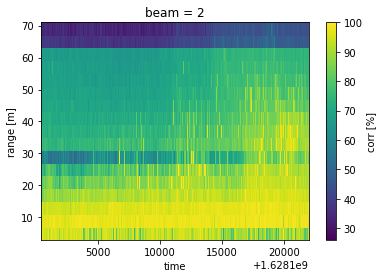

In [42]:
%matplotlib inline
dat.corr.sel(beam=1, range=slice(0,70)).plot()
%matplotlib inline
dat.corr.sel(beam=2, range=slice(0,70)).plot()

In [29]:
ds = api.clean.correlation_filter(ds, thresh=50)
ds

Data is already in the beam coordinate system
Data is already in the beam coordinate system


<xarray.Dataset>
Dimensions:              (beam: 4, dir: 4, dirIMU: 3, earth: 3, inst: 3, q: 4, range: 17, time: 1336, time_bt: 1336, x*: 4)
Coordinates:
  * dir                  (dir) int32 1 2 3 4
  * time_bt              (time_bt) float64 1.628e+09 1.628e+09 ... 1.628e+09
  * dirIMU               (dirIMU) <U1 'X' 'Y' 'Z'
  * time                 (time) float64 1.628e+09 1.628e+09 ... 1.628e+09
  * beam                 (beam) int32 1 2 3 4
  * range                (range) float64 5.0 9.0 13.0 17.0 ... 61.0 65.0 69.0
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/50)
    c_sound              (time) float32 1.5e+03 1.5e+03 ... 1.5e+03 1.5e+03
    temp                 (time) float32 15.05 15.06 15.07 ... 15.08 15.08 15.08
    pressure             (time) float32 0.838 0.838 0.838 ... 0.839 0.841 0.84
    heading              (time) float32 108.7 110.8 112.2 ... 133.5 133.5 133.6
    pitch                (time) float32 -0.06 0.25 -0.06 0.28 ... 0.13 0.27 0.2
    roll                 (time) float32 178.9 179.1 178.8 ... 179.4 179.4 179.4
    ...                   ...
    dist_bt              (dir, time_bt) float32 5.263 5.038 ... 8.188 8.188
    orientmat_bt         (earth, inst, time_bt) float32 0.9458 ... -0.9999
    angrt_bt             (dirIMU, time_bt) float32 0.008789 ... -0.00293
    quaternion_bt        (q, time_bt) float32 0.009155 0.008209 ... -0.0004272
    fom_bt               (dir, time_bt) uint16 16 33 15 18 21 ... 8 9 13 17 13
    beam2inst_orientmat  (beam, x*) float32 1.183 0.0 -1.183 ... 0.0 0.5518
Attributes: (12/35)
    filehead_config:    {'CLOCKSTR': {'TIME': '"2021-08-03 11:57:12"'}, 'ID':...
    inst_model:         Signature500
    inst_make:          Nortek
    inst_type:          ADCP
    rotate_vars:        ['vel', 'accel', 'accel_bt', 'angrt', 'angrt_bt', 'ma...
    burst_config:       {'press_valid': True, 'temp_valid': True, 'compass_va...
    ...                 ...
    coord_sys:          beam
    orientation:        AHRS
    orient_status:      AHRS-3D
    has_imu:            1
    fs:                 1
    principal_heading:  43.137

In [23]:
ds_avg['U_mag'] = ds_avg.velds.U_mag
ds_avg['U_dir'] = ds_avg.velds.U_dir
ds_avg['U_dir'].data = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)

%matplotlib inline
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
t = dlfn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg.range, ds_avg['U_mag'], cmap='Blues', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Horizontal Vel [m/s]')

C:\Users\SA01LD\Anaconda3\lib\site-packages\dolfyn\rotate\api.py:56: UserWarning: You are attempting to rotate into the 'principal' coordinate system, but the dataset is in the beam coordinate system. Be sure that 'principal_angle' is defined based on the earth coordinate system.
  warnings.warn(


AttributeError: 'Dataset' object has no attribute 'velds'